In [64]:
import numpy as np
import matplotlib.pyplot as plt
import solver.simple_hrl_solver 
from scipy.optimize import fsolve, curve_fit
import joblib as jl
import glob
import json

import matplotlib.cm
import matplotlib.colors
from matplotlib.lines import Line2D
import joblib as jl

In [701]:
def gram_schmidt(N, K):
    """
    Given the dimension space dimension N, generate K random vectors and its orthogonal spans
    """

    def proj(u, v):
        """
        Return projection of v to u
        """
        return np.dot(v, u) / np.dot(u, u) * u

    V = np.random.normal(loc=0., scale=1., size=(K, N))
    U = np.zeros_like(V)

    ## Initialise u1 to v1
    U[0] = V[0]

    ## Gram-schomidt process
    for k in range(1, K):
        projection_terms = [proj(U[i], V[k]) for i in range(k)]
        U[k] = V[k] - np.sum(projection_terms, axis=0)

    return V, U


def control_VS(VT, angle):
    dim = len(VT)
    VT_norm = VT / np.linalg.norm(VT)
    a = np.random.normal(loc=0., scale=0.1, size=(dim))
    b = np.random.normal(loc=0., scale=0.1, size=(dim))
    a[0]=0.
    b[0]=1.
    h = (b - a) - np.dot((b - a), VT_norm) * VT_norm
    v = np.cos(angle) * VT_norm + np.sin(angle) * h / np.linalg.norm(h)

    return v


In [702]:
N = 1000
Ts = [6]
Ks = [4]
identical = False
v_norm = 0
w_angle = np.pi/2
v_angle = np.pi/4
lr_w = 1.
lr_wc = 1.
lr_v = 1.
nums_iter = np.array([0, 400000])
update_frequency = 10

In [703]:
sim_dic = {}
ode_dic = {}
for i in range(1):
    for seq_length in Ts:
        for num_tasks in Ks:
            _, WT_sim = gram_schmidt(N, num_tasks)
            WS_sim = WT_sim.copy()
            for i, w in enumerate(WS_sim):
                w_rot = control_VS(w, w_angle) * np.sqrt(N)
                WS_sim[i] = w_rot
            WS_ode = WS_sim.copy()
    
            VT_sim = np.ones(num_tasks)
            VT_sim /= np.linalg.norm(VT_sim)
            VS_sim = control_VS(VT_sim, v_angle)
            VS_sim /= np.linalg.norm(VS_sim)
            temp=VS_sim[0]
            max_arg=np.argmax(abs(VS_sim))
            VS_sim[0] = VS_sim[max_arg]
            VS_sim[max_arg] = temp
            print(VS_sim)
            VS_ode = VS_sim.copy()
            VT_ode = VT_sim.copy()
            WS_ode = WS_sim.copy()
            WT_ode = WT_sim.copy()

            ode_solver = solver.HRLODESolver(VS=VS_ode,
                                             VT=VT_ode,
                                             WS=WS_ode,
                                             WT=WT_ode,
                                             lr_ws=np.array([lr_w, lr_wc]),
                                             lr_v=lr_v,
                                             seq_length=seq_length,
                                             N=N,
                                             V_norm=v_norm)
            ode_solver.train(nums_iter, update_frequency=update_frequency)

            sim = solver.simple_hrl_solver.CurriculumCompositionalTaskSimulator(
                input_dim=N,
                seq_len=seq_length,
                num_task=num_tasks,
                identical=False,
                WT=WT_sim,
                WS=WS_sim,
                VT=VT_sim,
                VS=VS_sim,
                V_norm=v_norm)

            sim.train(num_iter=nums_iter,
                      update_frequency=update_frequency,
                      lr={
                          'lr_w': lr_w,
                          'lr_wc': lr_wc,
                          'lr_vc': lr_v
                      })
            if not (seq_length, num_tasks) in sim_dic.keys():
                
                sim_dic[(seq_length, num_tasks)] = [sim]
                ode_dic[(seq_length, num_tasks)] = [ode_solver]
            else:
                sim_dic[(seq_length, num_tasks)].append(sim)
                ode_dic[(seq_length, num_tasks)].append(ode_solver)

[0.95777639 0.08397673 0.13033343 0.242127  ]


In [ ]:
print(VS_)

/tmp/ipykernel_149393/2183835778.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


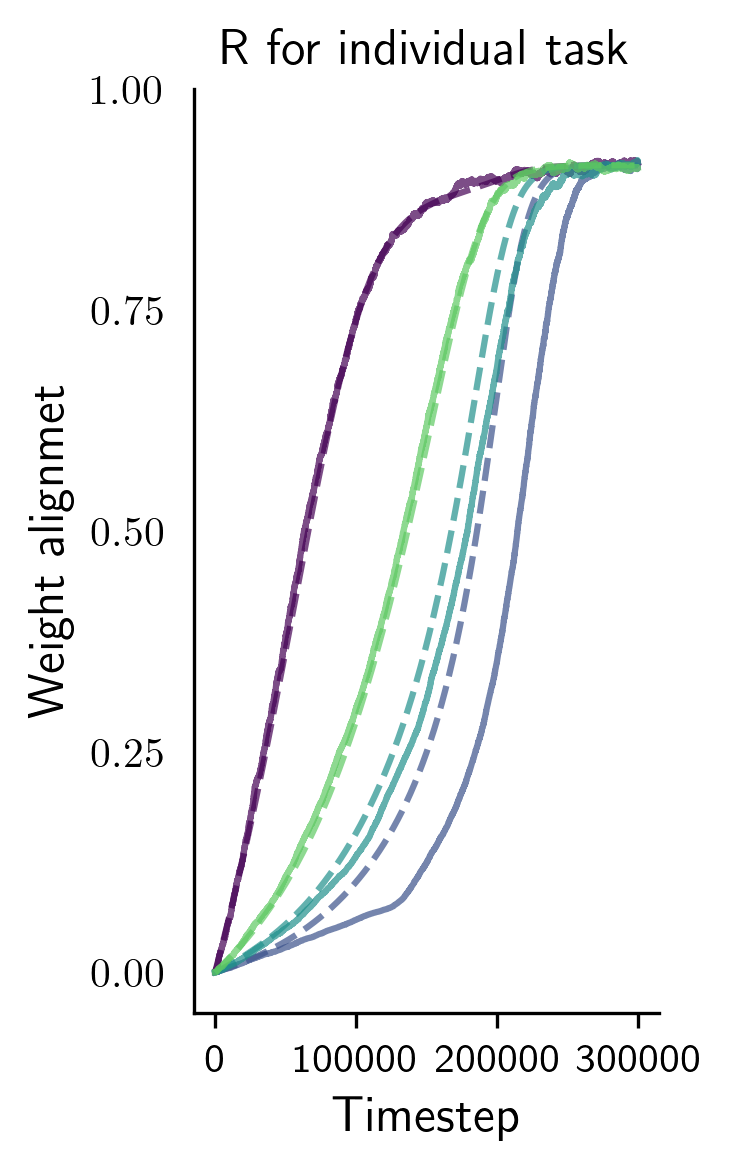

In [704]:
fig=plt.figure(figsize=(2,4), dpi = 300)

cmap = matplotlib.cm.get_cmap('viridis')
plt.rcParams['text.usetex'] = True

K = 4
T= 6
n=0
norm = matplotlib.colors.Normalize(vmin=0, vmax=K)
ax=plt.subplot(111)

line = Line2D([0], [0], label='simulation', color='k', alpha = 0.7)
dotted_line = Line2D([0], [0], label='theory', color='k', ls = '--', alpha = 0.7 )

for i in range(K):
    l=ax.plot(abs(sim_dic[T,K][n].history['R'][:,i,i][:30000]), c = cmap(norm(i)), label = i+1 ,alpha = 0.7)
    ax.plot(abs(ode_dic[T,K][n].history['phase2']['R'][:,i,i][:30000]), c = cmap(norm(i)), ls = '--', alpha = 0.7)
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line, dotted_line])
plt.title('R for individual task')
plt.xlabel('Timestep', fontsize=12)
plt.ylabel(r'Weight alignmet', fontsize=12)
plt.yticks(np.arange(0.0,1.25,0.25), fontsize=10)
plt.xticks(np.arange(0,40000, 10000), np.arange(0, 400000, 100000), fontsize=10)
ax.yaxis.set_ticks_position('none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend(handles = handles, title = 'primitive id', frameon = False, loc = 'lower right', fontsize=7)



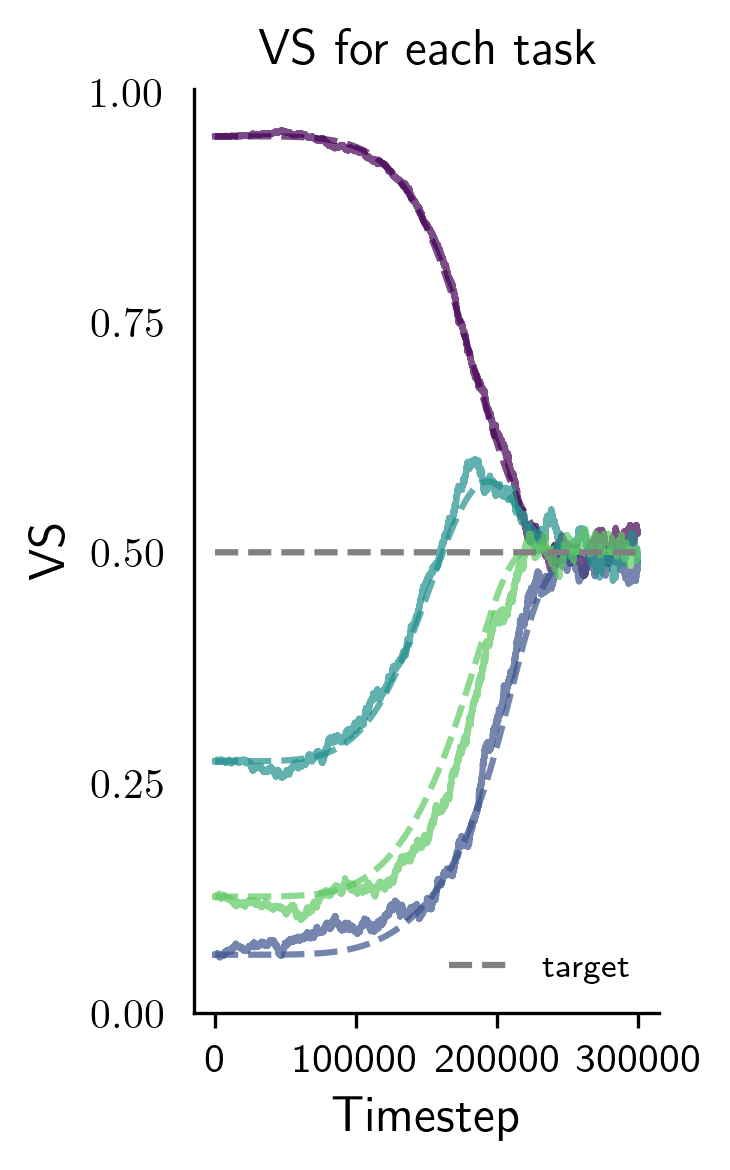

In [695]:
fig=plt.figure(figsize=(2,4), dpi=300)
ax =plt.subplot(111)
for i in range(K):
    ax.plot(abs(sim_dic[T,K][0].history['VS'][:30000,i][:]), c = cmap(norm(i)), alpha = 0.7)
    ax.plot(abs(ode_dic[T,K][0].history['phase2']['VS'][:30000,i][:]), c = cmap(norm(i)), ls = '--', alpha = 0.7)
plt.plot(np.arange(30000), np.ones(30000)*0.5, c= 'gray', ls = '--', label = r'target')
plt.title('VS for each task')
plt.xlabel('Timestep', fontsize=12)
plt.ylabel(r'VS', fontsize=12)
plt.yticks(np.arange(0.0,1.25,0.25), fontsize=10)
plt.xticks(np.arange(0,40000, 10000), np.arange(0, 400000, 100000), fontsize=10)
ax.yaxis.set_ticks_position('none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, loc = 'lower right', fontsize=8)


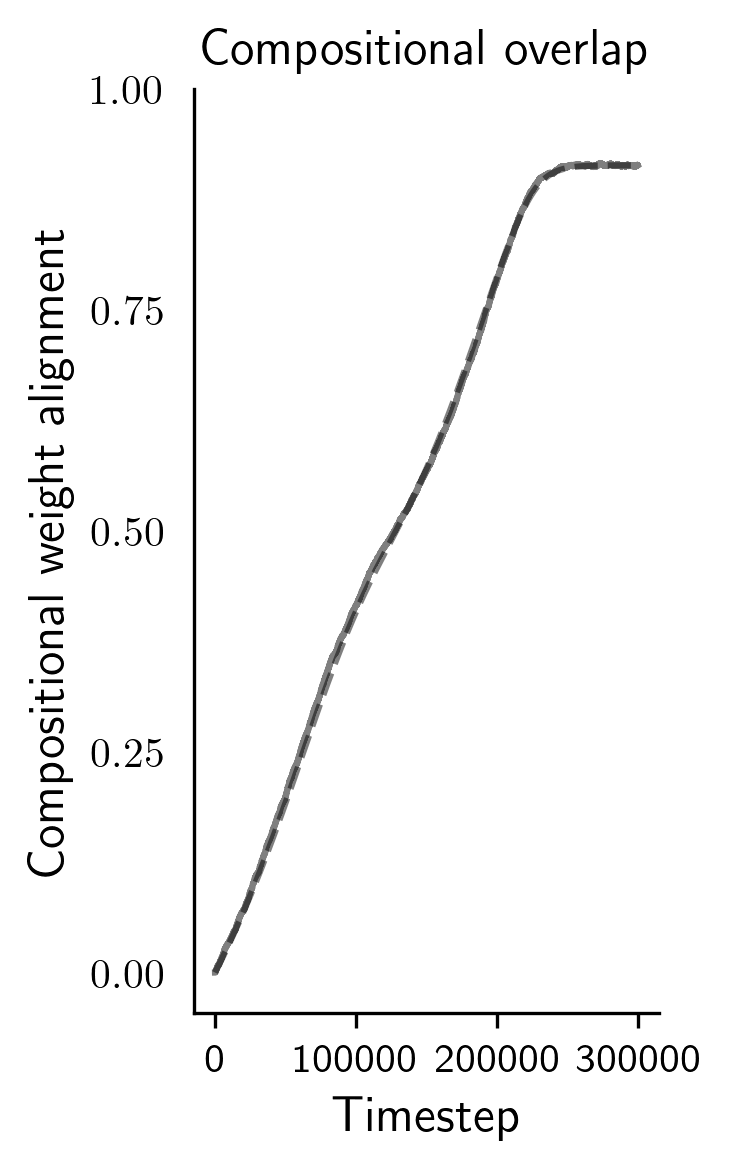

In [697]:
fig=plt.figure(figsize=(2,4), dpi= 300)
ax=plt.subplot(111)
ax.plot(sim_dic[T,K][0].history['overlap_tilde'][:30000], c = 'k', alpha = 0.5)
ax.plot(ode_dic[T,K][0].history['phase2']['overlap_tilde'][:30000], c = 'k', ls = '--', alpha = 0.5)
plt.title('Compositional overlap')
plt.xlabel('Timestep', fontsize=12)
plt.ylabel(r'Compositional weight alignment', fontsize=12)
plt.yticks(np.arange(0,1.25,0.25), fontsize=10)
plt.xticks(np.arange(0,40000, 10000), np.arange(0, 400000, 100000), fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('none') 

In [153]:
# 0.52 0.79 1.05 1.57 
w_angle = 1.05
v_angle = 1.05
def load_log(p):
    log =jl.load(p)
    args = json.load(open('/'.join(p.split('/')[:-1]) + '/args.json', 'r'))    
    return log, args

def get_training_time(p):
    log, args = load_log(p)
    num_tasks = args['num_tasks']
    seq_length = args['seq_length']
    pretrain_num_iter = 0
    composite_num_iter = 0
    num_iter = 0
    overlap_tilde = None
    if args['max_iters'][0] == 0: ##Baseline case
        if log['composite'] is not None and args['v_angle']==v_angle and args['w_angle']==w_angle:
            threshold = log['composite']['threshold']
            num_iter = log['composite']['iter']
            overlap_tilde = log['composite']['overlap_tilde']

    else:## Pretraining case
        if log['pretraining'] is not None and args['v_angle']==v_angle and args['w_angle']==w_angle:
            pretrain_threshold = log['pretraining']['threshold']
            pretrain_num_iter = log['pretraining']['iter']
            overlap = log['pretraining']['overlap_task']
        if log['composite'] is not None and args['v_angle']==v_angle and args['w_angle']==w_angle:
            composite_threshold = log['composite']['threshold']
            composite_num_iter = log['composite']['iter']
            overlap_tilde = log['composite']['overlap_tilde']
        
        num_iter = num_tasks * pretrain_num_iter + composite_num_iter
        
    
    return num_tasks, seq_length, num_iter, overlap_tilde

In [154]:
baseline_training_time = {}
for baseline_p in glob.glob('hrl_ode_logs/191023_baseline_training_time_vwangle/*/ode*'):
    num_tasks, seq_length, num_iter, overlap_tilde=get_training_time(baseline_p)
    if num_iter !=0:
        if (num_tasks, seq_length) not in baseline_training_time.keys():
            baseline_training_time[(num_tasks, seq_length)] = np.array([[num_iter, overlap_tilde]])
        else:
            baseline_training_time[(num_tasks, seq_length)]=np.vstack([baseline_training_time[(num_tasks, seq_length)], 
                                                                        [num_iter, overlap_tilde]])
            
curriculum_training_time = {}
for curriculum_p in glob.glob('hrl_ode_logs/191023_curriculum_training_time_vwangle/*/ode*'):
    num_tasks, seq_length, num_iter, overlap_tilde=get_training_time(curriculum_p)
    if num_iter !=0:
        if (num_tasks, seq_length) not in curriculum_training_time.keys():
            curriculum_training_time[(num_tasks, seq_length)] = np.array([[num_iter, overlap_tilde]])
        else:
            curriculum_training_time[(num_tasks, seq_length)]=np.vstack([curriculum_training_time[(num_tasks, seq_length)],
                                                                        [num_iter, overlap_tilde]])

In [155]:
num_tasks_list=np.unique(np.array(list(baseline_training_time.keys()))[:,0])
seq_length_list = np.unique(np.array(list(baseline_training_time.keys()))[:,1])

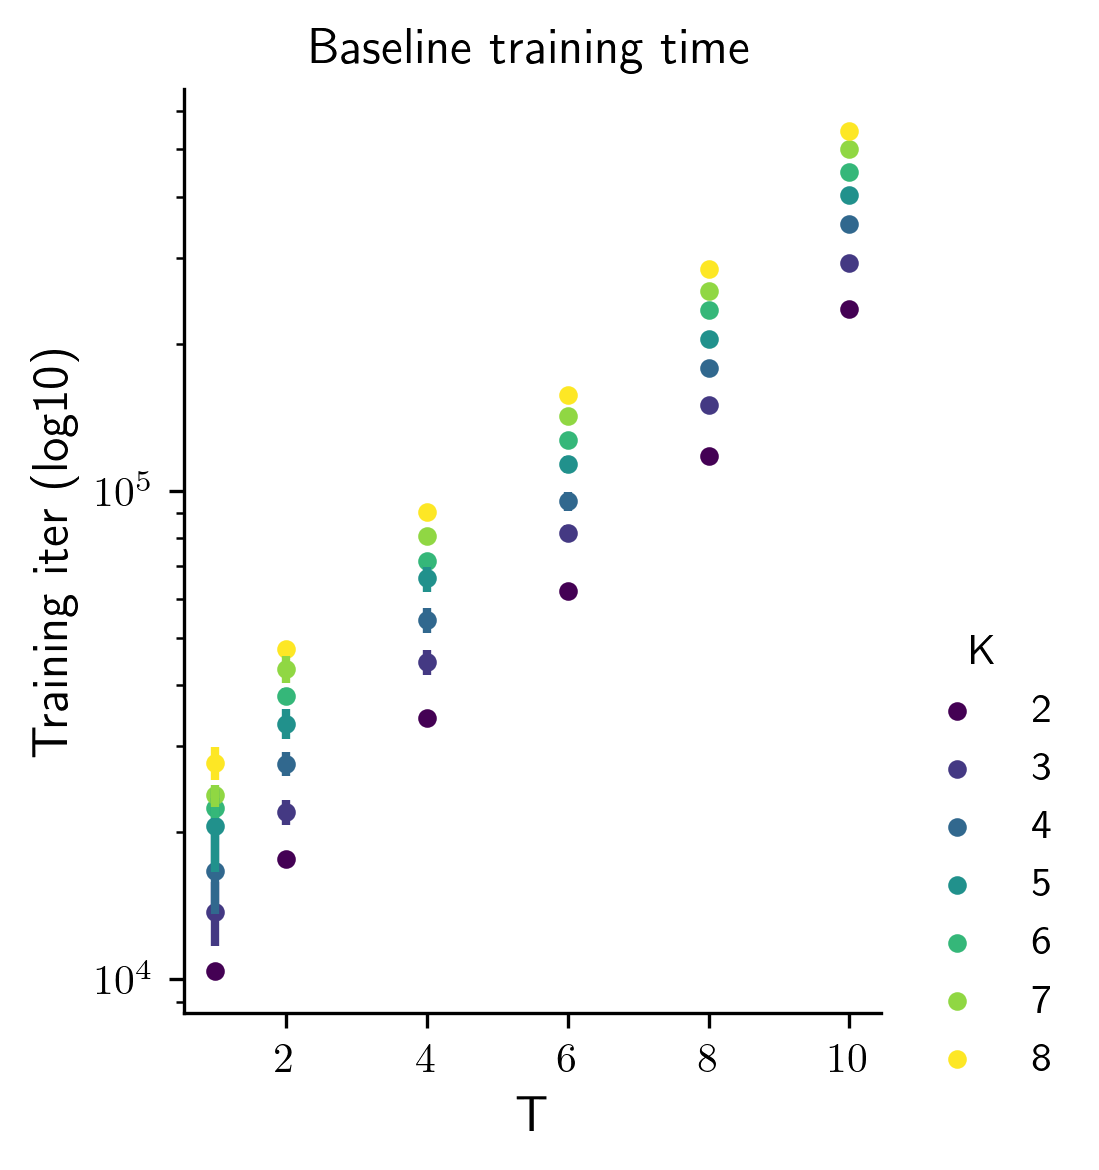

In [161]:
fig = plt.figure(figsize=(3,4), dpi = 300)
ax1 = plt.subplot(111)
cmap1=matplotlib.cm.viridis(range(0, len(num_tasks_list))/np.mean(range(0, len(num_tasks_list)))/2)
handles =[]
for i, num_task in enumerate(num_tasks_list):
    time_list=[[k[1],np.mean(v[:,0]), np.std(v[:,0])] for k, v in baseline_training_time.items() if k[0] == num_task]
    for seq_score in time_list:
        seq_length=seq_score[0]
        mean = seq_score[1]
        std= seq_score[2] + 1e-1
        seq=ax1.errorbar([seq_length], mean, yerr= std, color = cmap1[i],elinewidth =2)
        seq=ax1.scatter([seq_length], mean,  color = cmap1[i],s = 12,label = num_task)
    handles.append(seq)
    ax1.legend(handles = handles, title = 'K', frameon = False,  bbox_to_anchor=(1.3, 0.45),)
    ax1.set_yscale('log')
ax1.set_xlabel('T', fontsize=12)
ax1.set_ylabel('Training iter (log10)', fontsize=12)
ax1.set_title(f'Baseline training time ')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

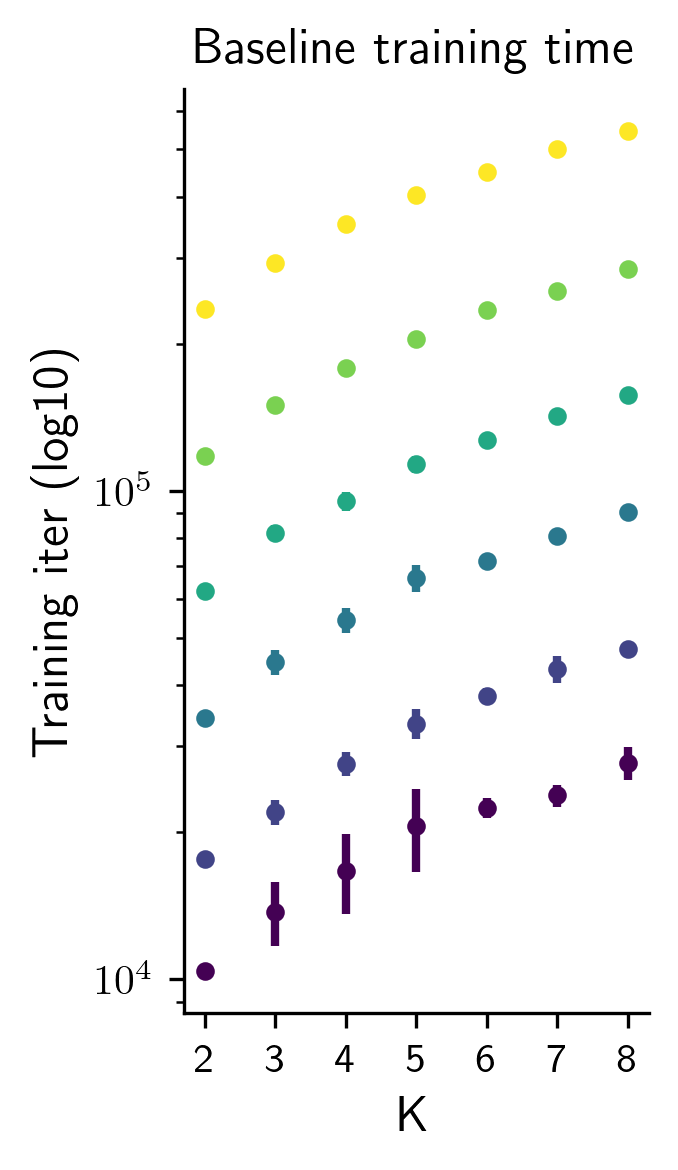

In [699]:
fig = plt.figure(figsize=(2,4), dpi = 300)
ax1 = plt.subplot(111)
cmap2=matplotlib.cm.viridis(range(0, len(seq_length_list))/np.mean(range(0, len(seq_length_list)))/2)
handles =[]
for i, seq_length in enumerate(seq_length_list):
    time_list=[[k[0],np.mean(v[:,0]), np.std(v[:,0])] for k, v in baseline_training_time.items() if k[1] == seq_length]
    for task_score in time_list:
        num_task=task_score[0]
        mean = task_score[1]
        std = task_score[2]
        task=ax1.errorbar([num_task], mean, yerr= std, color = cmap2[i],elinewidth =2)
        task=ax1.scatter([num_task], mean, color = cmap2[i], s=12, label = seq_length)
    handles.append(task)
    #ax1.legend(handles = handles, title = 'T', frameon = False, bbox_to_anchor=(1.3, 1.0),)
    ax1.set_yscale('log')
ax1.set_xlabel('K', fontsize=12)
ax1.set_xticks(np.arange(2,9))
ax1.set_xticklabels(np.arange(2,9))
ax1.set_ylabel('Training iter (log10)', fontsize=12)
#ax1.set_yticks(np.linspace(0, 5, 5), fontsize=12)
#ax1.set_yticklabels(np.linspace(0, 5, 5), fontsize=12)
ax1.set_title(f'Baseline training time ')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

In [ ]:
s

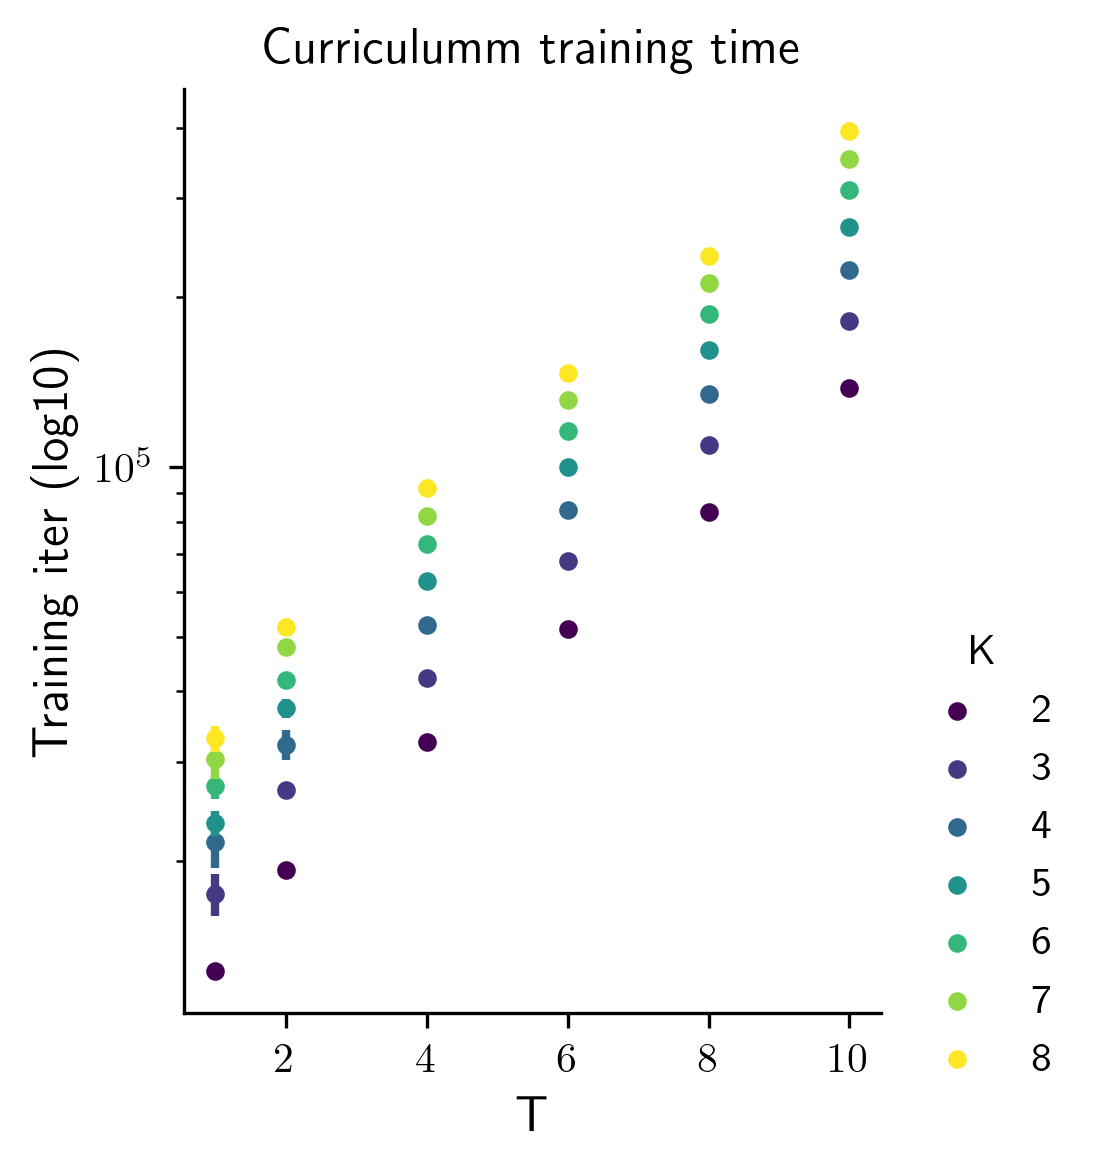

In [158]:
fig = plt.figure(figsize=(3,4), dpi = 300)
ax1 = plt.subplot(111)
cmap1=matplotlib.cm.viridis(range(0, len(num_tasks_list))/np.mean(range(0, len(num_tasks_list)))/2)
handles =[]
for i, num_task in enumerate(num_tasks_list):
    time_list=[[k[1],np.mean(v[:,0]), np.std(v[:,0])] for k, v in curriculum_training_time.items() if k[0] == num_task]
    for seq_score in time_list:
        seq_length=seq_score[0]
        mean = seq_score[1]
        std= seq_score[2] + 1e-1
        seq=ax1.errorbar([seq_length], mean, yerr= std, color = cmap1[i],elinewidth =2)
        seq=ax1.scatter([seq_length], mean,  color = cmap1[i],s = 12,label = num_task)
    handles.append(seq)
    ax1.legend(handles = handles, title = 'K', frameon = False,  bbox_to_anchor=(1.3, 0.45),)
    ax1.set_yscale('log')
ax1.set_xlabel('T', fontsize=12)
ax1.set_ylabel('Training iter (log10)', fontsize=12)
ax1.set_title(f'Curriculumm training time ')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

In [166]:
difference_percent={k: np.mean(v[:,0])/np.mean(curriculum_training_time[k][:,0]) for k,v in baseline_training_time.items() if k in curriculum_training_time.keys()}
difference_percent_heatmap = np.ones((len(num_tasks_list), len(seq_length_list)))

num_tasks_list=np.unique(np.array(list(difference_percent.keys()))[:,0])
seq_length_list = np.unique(np.array(list(difference_percent.keys()))[:,1])

for i,task in enumerate(num_tasks_list):
    for j, seq in enumerate(seq_length_list):
        try:
            difference_percent_heatmap[i][j] = difference_percent[(task,seq)]
        except:
            pass
        

In [194]:
baseline_training_time

{(2,
  1): array([[1.03960000e+04, 6.34765749e-01],
        [1.03960000e+04, 6.34765749e-01],
        [1.03960000e+04, 6.34765749e-01],
        [1.03960000e+04, 6.34765749e-01],
        [1.03960000e+04, 6.34765749e-01]]),
 (3,
  1): array([[1.32880000e+04, 6.34764268e-01],
        [1.64550000e+04, 6.34764455e-01],
        [1.06030000e+04, 6.34763316e-01],
        [1.54620000e+04, 6.34763204e-01],
        [1.28740000e+04, 6.34761716e-01]]),
 (4,
  1): array([[2.15500000e+04, 6.34763115e-01],
        [1.90890000e+04, 6.34761809e-01],
        [1.35060000e+04, 6.34762543e-01],
        [1.42510000e+04, 6.34761733e-01],
        [1.50320000e+04, 6.34762626e-01]]),
 (5,
  1): array([[1.59370000e+04, 6.34762525e-01],
        [1.93530000e+04, 6.34761618e-01],
        [2.78380000e+04, 6.34761436e-01],
        [2.10760000e+04, 6.34762100e-01],
        [1.85970000e+04, 6.34762874e-01]]),
 (6,
  1): array([[2.37050000e+04, 6.34762731e-01],
        [2.08880000e+04, 6.34761316e-01],
        [2.2115000

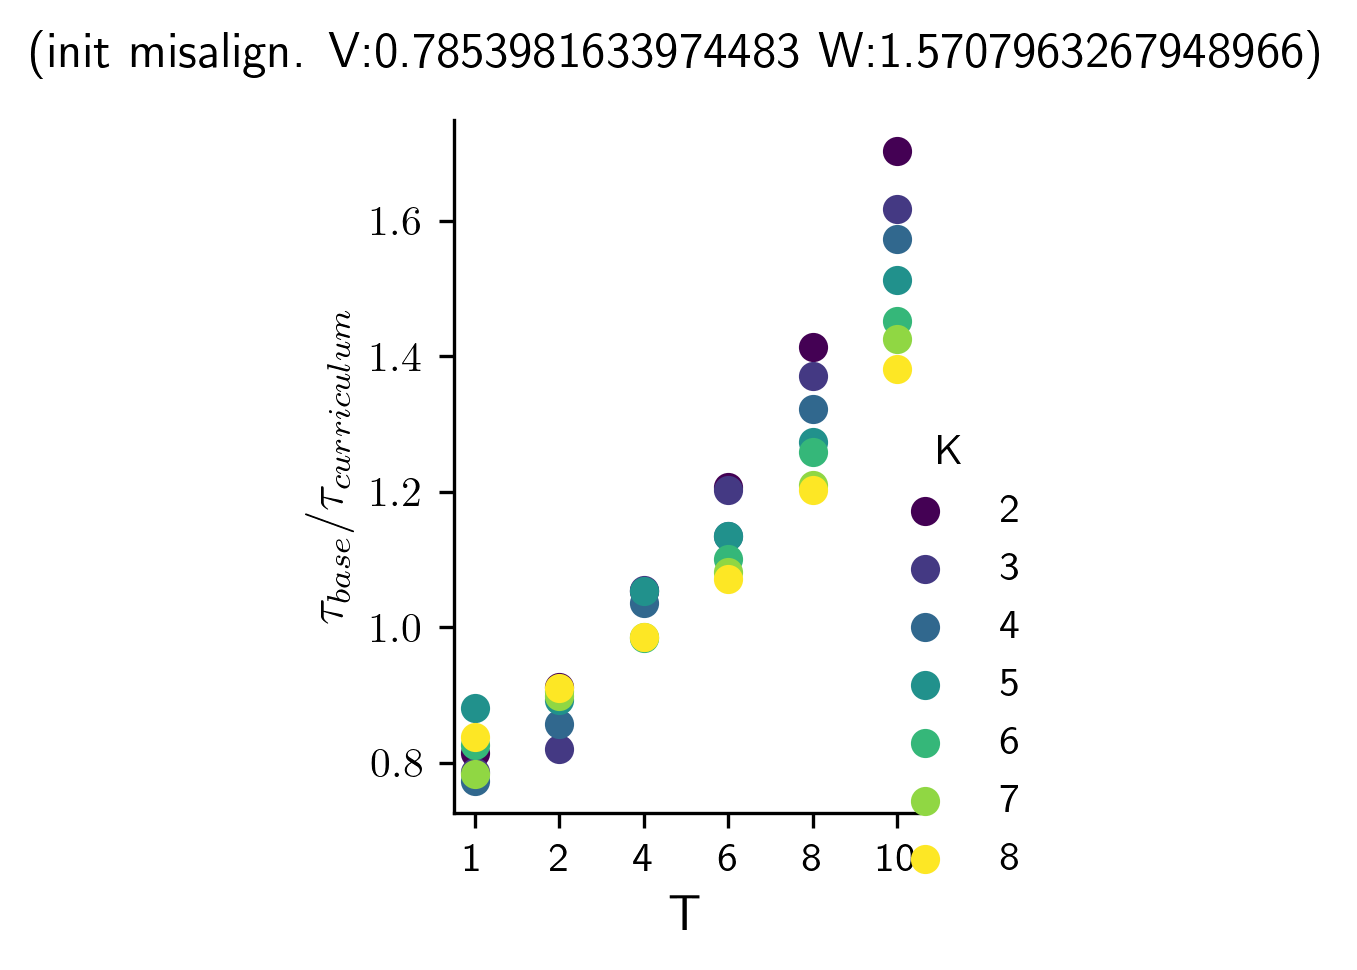

In [688]:
fig = plt.figure(figsize=(2,3), dpi = 300)
ax1 = plt.subplot(111)
plt.suptitle(f'(init misalign. V:{v_angle} W:{w_angle})')
handles=[]
cmap=matplotlib.cm.viridis(range(0, len(num_tasks_list))/np.mean(range(0, len(num_tasks_list)))/2)
for i in range(difference_percent_heatmap.shape[0]):
    for j in range(difference_percent_heatmap.shape[1]):
        task = ax1.scatter(j, difference_percent_heatmap[i,j], color = cmap[i], label = num_tasks_list[i]) ## i: task, j : seq_len
    handles.append(task)

ax1.set_xlabel('T', fontsize=12)
ax1.set_ylabel(r'$\tau_{base}/\tau_{curriculum}$', fontsize=12) 
ax1.set_xticks(np.arange(len(seq_length_list)), seq_length_list)
ax1.legend(handles = handles, title = 'K', frameon = False, bbox_to_anchor = (1.3, 0.6))

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

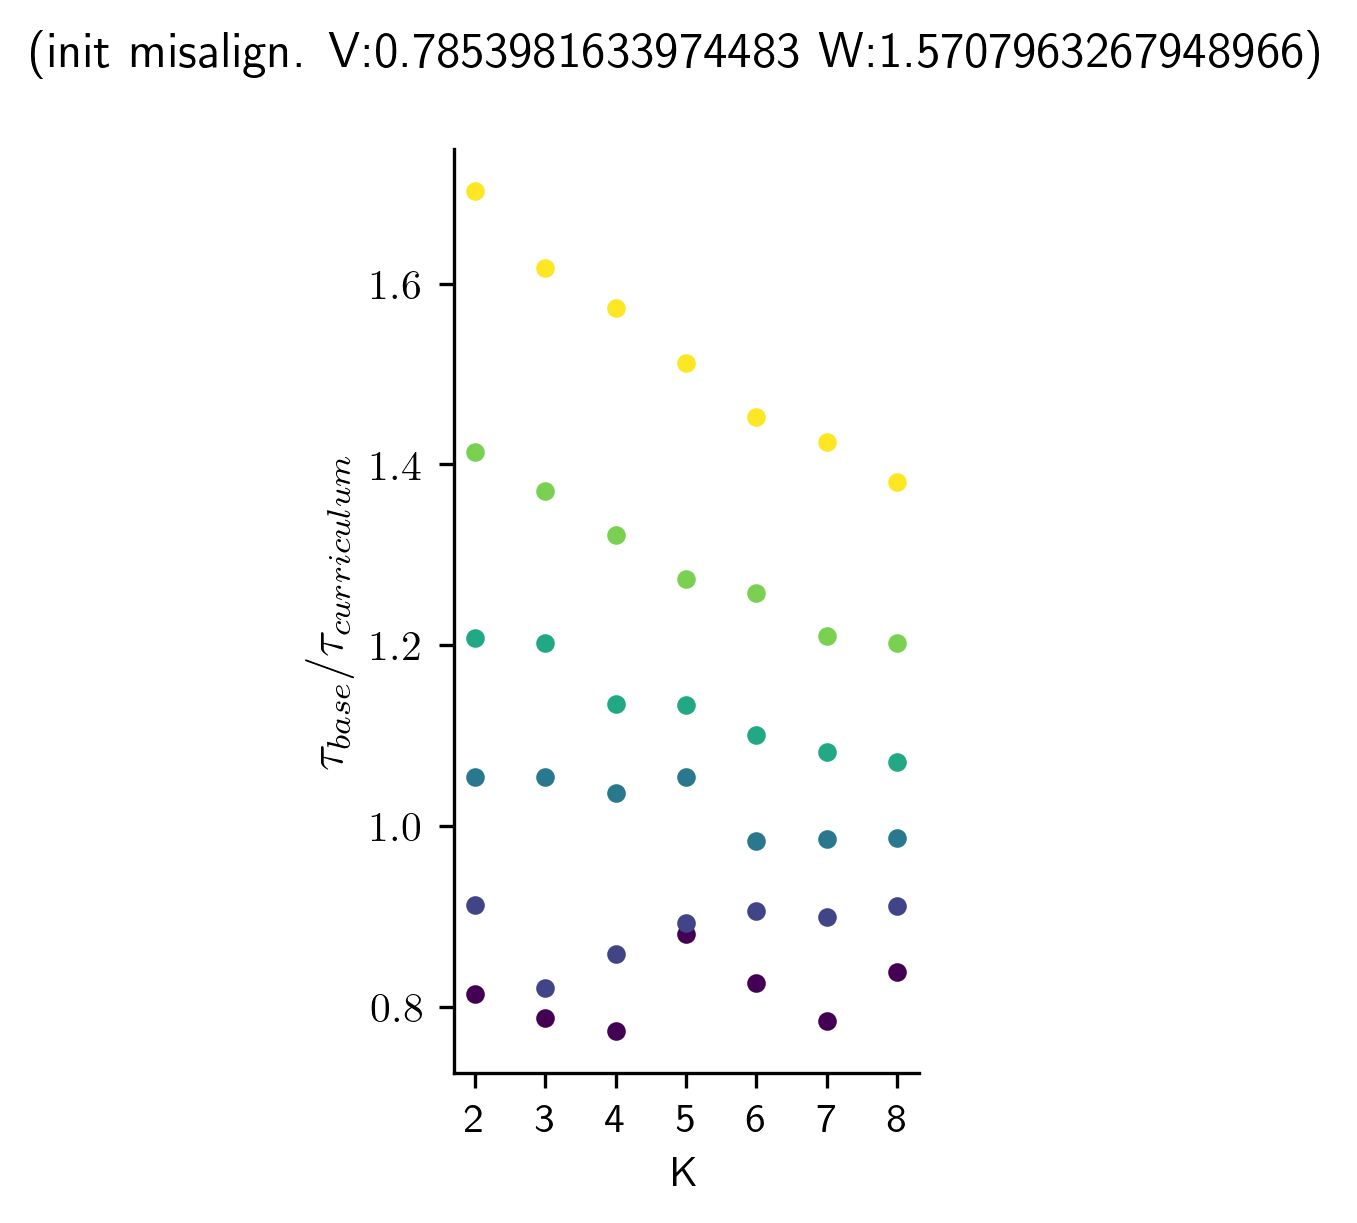

In [700]:
fig = plt.figure(figsize=(2,4), dpi = 300)
ax2 = plt.subplot(111)
handles=[]
plt.suptitle(f'(init misalign. V:{v_angle} W:{w_angle})')

cmap=matplotlib.cm.viridis(range(0, len(seq_length_list))/np.mean(range(0, len(seq_length_list)))/2)
for i in range(difference_percent_heatmap.shape[1]):
    for j in range(difference_percent_heatmap.shape[0]):
        seq = ax2.scatter(j, difference_percent_heatmap[j,i], color = cmap[i], s=12, label = seq_length_list[i]) 
    handles.append(seq)

ax2.set_xlabel('K')
ax2.set_ylabel(r'$\tau_{base}/\tau_{curriculum}$', fontsize=12) 
#ax2.legend(handles = handles, title = 'T', frameon = False, bbox_to_anchor = (1.35, 0.5))
ax2.set_xticks(np.arange(len(num_tasks_list)), num_tasks_list)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

In [524]:
sim_dic_base_curr = {'base':{}, 'curr':{}}
ode_dic_base_curr = {'base':{}, 'curr':{}}

w_angle = 1.57
v_angle = 0.78

nums_iter_curr = np.array([200000, 100000])

for seq_length in [6,7]:
    for num_tasks in [4]:
        _, WT_sim = gram_schmidt(N, num_tasks)
        WS_sim = WT_sim.copy()
        for i, w in enumerate(WS_sim):
            w_rot = control_VS(w, w_angle) * np.sqrt(N)
            WS_sim[i] = w_rot
        WS_ode = WS_sim.copy()

        VS_sim = np.random.normal(loc = 0, scale = 0.1, size=num_tasks)
        VS_sim[0] = np.sqrt(1 - np.dot(VS_sim[1:], VS_sim[1:]))
        print(VS_sim)
        VS_sim /= np.linalg.norm(VS_sim)
        VS_sim_curr = VS_sim.copy()
        VS_ode = VS_sim.copy()
        VS_ode_curr = VS_sim.copy()
        VT_ode = VT_sim.copy()
        VT_ode_curr = VT_sim.copy()
        VT_sim_curr = VT_sim.copy()
        WS_ode = WS_sim.copy()
        WS_ode_curr = WS_sim.copy()
        WS_sim_curr = WS_sim.copy()
        WT_ode = WT_sim.copy()
        WT_ode_curr = WT_sim.copy()
        WT_sim_curr = WT_sim.copy()
        
        ode_solver = solver.HRLODESolver(VS=VS_ode,
                                         VT=VT_ode,
                                         WS=WS_ode,
                                         WT=WT_ode,
                                         lr_ws=np.array([lr_w, lr_wc]),
                                         lr_v=lr_v,
                                         seq_length=seq_length,
                                         N=N,
                                         V_norm=v_norm)
        ode_solver_curr = solver.HRLODESolver(VS=VS_ode_curr,
                                         VT=VT_ode_curr,
                                         WS=WS_ode_curr,
                                         WT=WT_ode_curr,
                                         lr_ws=np.array([lr_w, lr_wc]),
                                         lr_v=lr_v,
                                         seq_length=seq_length,
                                         N=N,
                                         V_norm=v_norm)
        ode_solver.train(nums_iter, update_frequency=update_frequency)

        ode_solver_curr.train(nums_iter_curr, update_frequency=update_frequency)

        sim = solver.simple_hrl_solver.CurriculumCompositionalTaskSimulator(
            input_dim=N,
            seq_len=seq_length,
            num_task=num_tasks,
            identical=False,
            WT=WT_sim,
            WS=WS_sim,
            VT=VT_sim,
            VS=VS_sim,
            V_norm=v_norm)
        
        sim_curr = solver.simple_hrl_solver.CurriculumCompositionalTaskSimulator(
            input_dim=N,
            seq_len=seq_length,
            num_task=num_tasks,
            identical=False,
            WT=WT_sim_curr,
            WS=WS_sim_curr,
            VT=VT_sim_curr,
            VS=VS_sim_curr,
            V_norm=v_norm)

        sim.train(num_iter=nums_iter,
                  update_frequency=update_frequency,
                  lr={
                      'lr_w': lr_w,
                      'lr_wc': lr_wc,
                      'lr_vc': lr_v
                  })
        sim_curr.train(num_iter=nums_iter_curr,
                  update_frequency=update_frequency,
                  lr={
                      'lr_w': lr_w,
                      'lr_wc': lr_wc,
                      'lr_vc': lr_v
                  })
        sim_dic_base_curr['base'][(seq_length, num_tasks)] = sim
        sim_dic_base_curr['curr'][(seq_length, num_tasks)] = sim_curr
        ode_dic_base_curr['base'][(seq_length, num_tasks)] = ode_solver
        ode_dic_base_curr['curr'][(seq_length, num_tasks)] = ode_solver_curr
        

[ 0.96347521  0.07446824 -0.2563707  -0.02107282]


/nfs/nhome/live/jlee/rotation_saxe/composite_learning/solver/simple_hrl_solver.py:530: RuntimeWarning: invalid value encountered in sqrt
  dR = self.lr_w1 / self.N / sqrt2pi * (np.diag(np.sqrt(
/nfs/nhome/live/jlee/rotation_saxe/composite_learning/solver/simple_hrl_solver.py:531: RuntimeWarning: invalid value encountered in sqrt
  self.S)) + np.diag(self.R) / np.diag(np.sqrt(self.Q))) * np.power(
/nfs/nhome/live/jlee/rotation_saxe/composite_learning/solver/simple_hrl_solver.py:534: RuntimeWarning: invalid value encountered in sqrt
  self.Q)) + np.diag(self.R) / np.diag(np.sqrt(self.S))) * np.power(


[ 0.99608327 -0.03838732  0.07735966 -0.01897411]


In [527]:
pretrain_length = 5000
adaptation_length = 5000
K=4
T=6
ode_overlap_task_pretrain=ode_dic_base_curr['curr'][T,K].history['phase1']['R'][:pretrain_length]
ode_overlap_task_adaptation = ode_dic_base_curr['curr'][T,K].history['phase2']['R'][:adaptation_length]
ode_overlap_VS_pretrain= np.tile(ode_dic_base_curr['curr'][T,K].history['phase2']['VS'][0], [pretrain_length * K,1])
ode_overlap_VS_adaptation=ode_dic_base_curr['curr'][T,K].history['phase2']['VS'][:adaptation_length]

sim_overlap_task_pretrain=sim_dic_base_curr['curr'][T,K].history['R'][:pretrain_length]
sim_overlap_task_adaptation = sim_dic_base_curr['curr'][T,K].history['R'][int(nums_iter_curr[0]//10):(int(nums_iter_curr[0]//10) +adaptation_length)]
sim_overlap_VS_pretrain= np.tile(sim_dic_base_curr['curr'][T,K].history['VS'][int(nums_iter_curr[0]//10)], [pretrain_length * K,1])
sim_overlap_VS_adaptation=sim_dic_base_curr['curr'][T,K].history['VS'][int(nums_iter_curr[0]//10):(int(nums_iter_curr[0]//10) +adaptation_length)]


/tmp/ipykernel_149393/1295562087.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


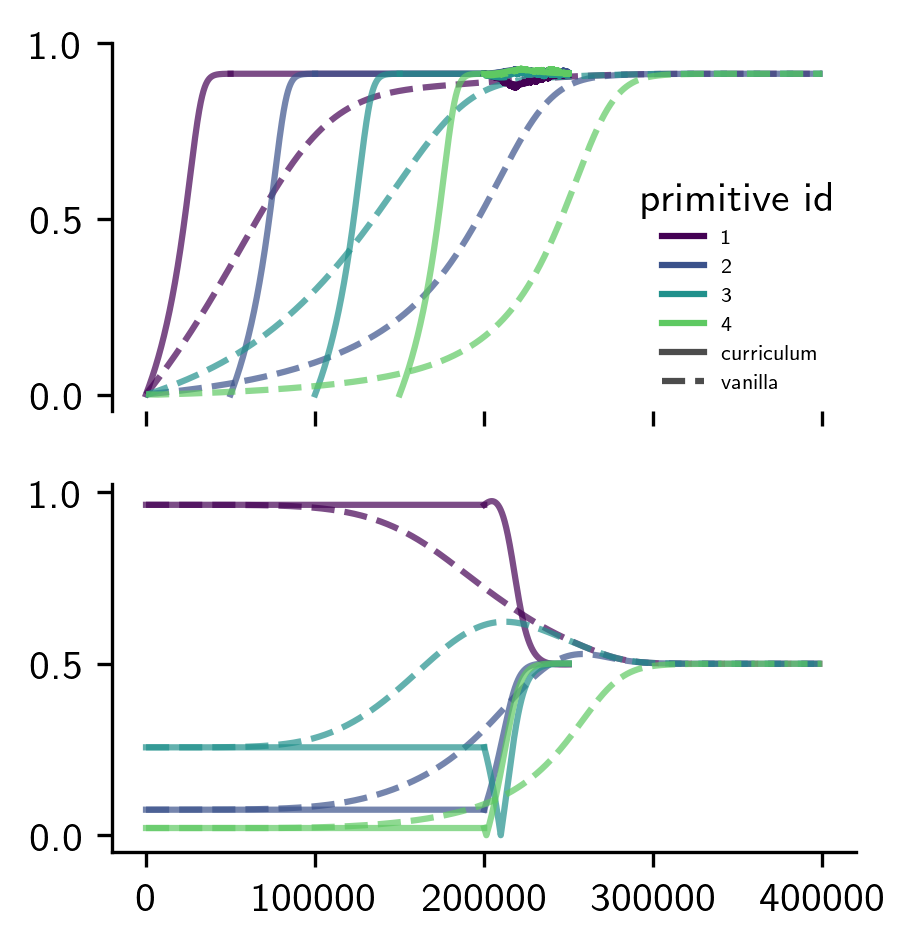

In [690]:

cmap = matplotlib.cm.get_cmap('viridis')
plt.rcParams['text.usetex'] = True

norm = matplotlib.colors.Normalize(vmin=0, vmax=K)

line = Line2D([0], [0], label='curriculum', color='k', alpha = 0.7)
dotted_line = Line2D([0], [0], label='vanilla', color='k', ls = '--', alpha = 0.7 )

fig, axs= plt.subplots(2,1, sharex=True, dpi = 300, figsize=(3.2,3.5))
ax1=axs[0]
ax2=axs[1]
handles, labels = plt.gca().get_legend_handles_labels()
for k in range(K):

    ax1.plot(np.arange(k* pretrain_length, (k+1)*pretrain_length ), ode_overlap_task_pretrain[:,0,0],
            c = cmap(norm(k)), alpha = 0.7)
    
    
    ax1.plot(np.arange((k+1)* pretrain_length, K*pretrain_length ), 
             np.tile(ode_overlap_task_pretrain[pretrain_length-1,0,0],(K-k-1) * pretrain_length),
            c = cmap(norm(k)), alpha = 0.7)

    ax1.plot(abs(ode_dic_base_curr['base'][T,K].history['phase2']['R'][:, k,k]),  
             ls= '--', c = cmap(norm(k)), alpha = 0.7)
    
for k in range(K):
    l,=ax1.plot(np.arange(K* pretrain_length, K* pretrain_length+ adaptation_length), 
             ode_overlap_task_adaptation[:,k,k], c = cmap(norm(k)), label = k+1)
    ax1.plot(np.arange(K* pretrain_length, K* pretrain_length+ adaptation_length), 
             sim_overlap_task_adaptation[:,k,k], c = cmap(norm(k)), ls = '--'  )
    handles.append(l)
handles.extend([line, dotted_line])
ax1.legend(handles = handles, title = 'primitive id', frameon = False, loc = 'lower right', fontsize=5)

ax1.set_yticks(np.arange(0, 1.5, 0.5))
ax1.set_yticklabels(np.arange(0, 1.5, 0.5))
ax1.set_xticks([])
ax1.set_xticks([], minor = True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)


for k in range(K):
    ax2.plot(abs(ode_overlap_VS_pretrain[:,k]), c = cmap(norm(k)), alpha = 0.7)
    ax2.plot(np.arange(K*pretrain_length, K* pretrain_length+adaptation_length), 
             abs(ode_overlap_VS_adaptation[:,k]), c = cmap(norm(k)), alpha = 0.7)
    ax2.plot(abs(ode_dic_base_curr['base'][T,K].history['phase2']['VS'][:, k]), 
             c = cmap(norm(k)), ls= '--', alpha = 0.7)
ax2.set_xticks(np.linspace(0, 40000, 5, dtype = int))
ax2.set_xticklabels(np.linspace(0, 400000, 5, dtype = int))

ax2.set_yticks(np.arange(0, 1.5, 0.5))
ax2.set_yticklabels(np.arange(0, 1.5, 0.5))


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

In [468]:

cmap = matplotlib.cm.get_cmap('viridis')
plt.rcParams['text.usetex'] = True

norm = matplotlib.colors.Normalize(vmin=0, vmax=K)

line = Line2D([0], [0], label='curriculum', color='k', alpha = 0.7)
dotted_line = Line2D([0], [0], label='vanilla', color='k', ls = '--', alpha = 0.7 )

fig, axs= plt.subplots(2,1, sharex=True, dpi = 300, figsize=(3,6))
ax1=axs[0]
ax2=axs[1]
handles, labels = plt.gca().get_legend_handles_labels()
for k in range(K):
    ax1.plot(np.arange(k* pretrain_length, (k+1)*pretrain_length ), ode_overlap_task_pretrain[:,0,0],
            c = cmap(norm(k)), alpha = 0.7)
    
    
    ax1.plot(np.arange((k+1)* pretrain_length, K*pretrain_length ), 
             np.tile(ode_overlap_task_pretrain[pretrain_length-1,0,0],(K-k-1) * pretrain_length),
            c = cmap(norm(k)), alpha = 0.7)

    ax1.plot(ode_dic_base_curr['base'][T,K].history['phase2']['R'][:40000, k,k], 
             c = cmap(norm(k)), ls= '--', alpha = 0.7)
    
for k in range(K):
    l,=ax1.plot(np.arange(K* pretrain_length, K* pretrain_length+ adaptation_length), 
             ode_overlap_task_adaptation[:,k,k], c = cmap(norm(k)), label = k+1)
    ax1.plot(np.arange(K* pretrain_length, K* pretrain_length+ adaptation_length), 
             sim_overlap_task_adaptation[:,k,k], c = cmap(norm(k)), ls = '--'  )
    handles.append(l)
handles.extend([line, dotted_line])
ax1.legend(handles = handles, title = 'Primitive ID', frameon = False, loc = 'lower right', fontsize=5)

ax1.set_yticks(np.arange(0, 1.5, 0.5))
ax1.set_yticklabels(np.arange(0, 1.5, 0.5))
ax1.set_xticks([])
ax1.set_xticks([], minor = True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)


for k in range(K):
    ax2.plot(ode_overlap_VS_pretrain[:,k], c = cmap(norm(k)), alpha = 0.7)
    ax2.plot(np.arange(K*pretrain_length, K* pretrain_length+adaptation_length), 
             ode_overlap_VS_adaptation[:,k], c = cmap(norm(k)), alpha = 0.7)
    ax2.plot(ode_dic_base_curr['base'][T,K].history['phase2']['VS'][:40000, k], 
             c = cmap(norm(k)), ls= '--', alpha = 0.7)
ax2.set_xticks(np.linspace(0, 40000, 5, dtype = int))
ax2.set_xticklabels(np.linspace(0, 400000, 5, dtype = int))

ax2.set_yticks(np.arange(0, 1.5, 0.5))
ax2.set_yticklabels(np.arange(0, 1.5, 0.5))


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

[[<matplotlib.lines.Line2D at 0x7fa0f17591b0>],

ValueError: x and y can be no greater than 2D, but have shapes (2000,) and (2000, 4, 4)

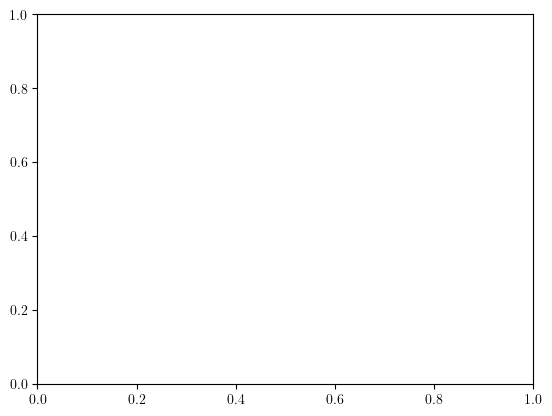

In [313]:
plt.plot(ode_overlap_task_adaptation)

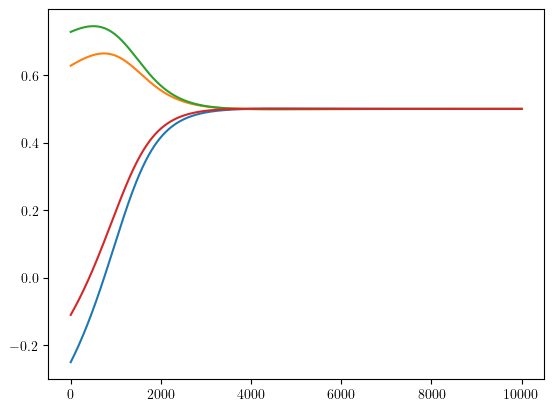

In [245]:
plt.plot(ode_dic_base_curr['curr'][6,4].history['phase2']['VS'])

In [236]:
VT_sim

array([1., 1., 1., 1.])